In [1]:
# Install necessary libraries in Colab
!pip install -q spacy xgboost shap lime joblib tqdm wordcloud

# Download English language model for spaCy (used in lemmatization)
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 116.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Dataset/depression_detection.csv")

#keep only "text" and "label" column
df = df[['text', 'label']]

# Check first 5 rows
df.head(10)


,text,label
0,i'm tired of my life and i'm not sure what to ...,1
1,"33, heartbroken and alone, with no future hope...",1
2,let's see what else i can cram in with two day...,0
3,"day 40, ending it all anyway, nothing happened...",0
4,guys the results are here.. megathiccc is best...,0
5,"can you enjoy exercise, food, sun when you are...",1
6,i just blew an opportunity to work for google ...,1
7,"""dime 3 palabras para definirte a ti mismo...""...",1
8,i really liked this nice quote.[here](http://m...,1
9,"""depression is for the weak minded"" so here's ...",0


In [4]:
# Print original dataframe length
print("Original rows:", len(df))

# Keep a copy of original labels to see what will be dropped
original_labels = df['label'].copy()

# Keep only rows where label is 0, 1, 0.0, or 1.0
df = df[df['label'].isin([0, 1, 0.0, 1.0])]

# Find and print rows that were dropped
dropped_rows = original_labels[~original_labels.isin([0, 1, 0.0, 1.0])]
print("Dropped rows distribution:")
print(dropped_rows.value_counts())
print("Number of dropped rows:", len(dropped_rows))

# Convert all labels to integer
df['label'] = df['label'].astype(int)

# Drop rows with empty text (just in case)
df = df.dropna(subset=['text']).reset_index(drop=True)

# Check final distribution
print("Final rows:", len(df))
print("Label distribution:")
print(df['label'].value_counts())


Original rows: 120000
Dropped rows distribution:
Series([], Name: count, dtype: int64)
Number of dropped rows: 0
Final rows: 120000
Label distribution:
label
1    60218
0    59782
Name: count, dtype: int64


In [5]:
print(df.columns)
print(len(df))
print(df['label'].value_counts())

Index(['text', 'label'], dtype='object')
120000
label
1    60218
0    59782
Name: count, dtype: int64


In [6]:
import pandas as pd

# Separate the two classes
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

# Sample 25,000 rows from each class
class_0_sample = class_0.sample(n=25000, random_state=42)
class_1_sample = class_1.sample(n=25000, random_state=42)

# Concatenate the samples to create balanced dataset
balanced_df = pd.concat([class_0_sample, class_1_sample]).reset_index(drop=True)

# Shuffle the final dataframe
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the distribution
print("Balanced dataset size:", len(balanced_df))
print("Label distribution:")
print(balanced_df['label'].value_counts())


save_path = '/content/drive/My Drive/Dataset/balanced_dataset_50k.csv'

# Save as CSV
balanced_df.to_csv(save_path, index=False)


Balanced dataset size: 50000
Label distribution:
label
1    25000
0    25000
Name: count, dtype: int64


In [7]:
balanced_df.shape

(50000, 2)

In [8]:
balanced_df.head()

,text,label
0,been a long time sufferer of depression myself...,1
1,i'm speedrunnig a single mario maker 2 level i...,0
2,my mom and dad are getting a divorce and i don...,0
3,just ate chocolate at 2:30 am delicious ok goo...,0
4,how can i help a friend that has stress?my fri...,1


In [9]:
balanced_df.isnull().sum()

,0
text,0
label,0


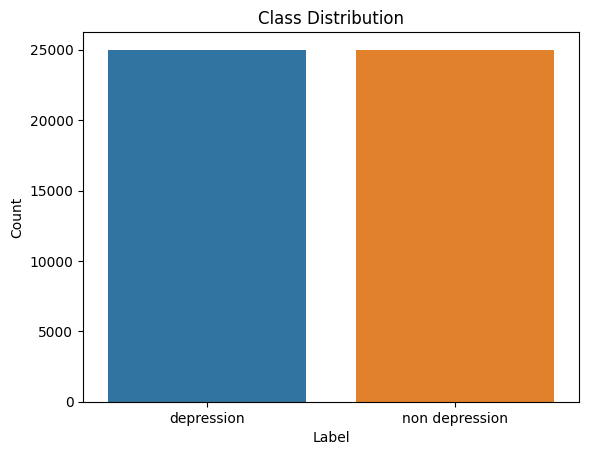

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

label_map = {0: "non depression", 1: "depression"}


sns.countplot(
    data=balanced_df,
    x=balanced_df["label"].map(label_map),   # apply mapping only for plotting
    hue=balanced_df["label"].map(label_map)
)

plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


In [11]:
import string
import re
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [12]:
df_clean = balanced_df.copy()
df_clean

,text,label
0,been a long time sufferer of depression myself...,1
1,i'm speedrunnig a single mario maker 2 level i...,0
2,my mom and dad are getting a divorce and i don...,0
3,just ate chocolate at 2:30 am delicious ok goo...,0
4,how can i help a friend that has stress?my fri...,1
...,...,...
49995,my youtube channel and opinions/help ive been ...,0
49996,dae contemplate the moment they will break fro...,1
49997,are there any other suicide websites you know ...,1
49998,tell me what is your favorite thing you ate to...,0


In [13]:
#lower the text
df_clean['text'] = df_clean['text'].str.lower()

In [14]:
def remove_digits(text):
  return text.translate(str.maketrans('', '', string.digits))

In [15]:
#remove digits
df_clean['text'] = df_clean['text'].apply(remove_digits)

In [16]:
#remove punctuations
def remove_punc(text):
  return text.translate(str.maketrans('', '', string.punctuation))

In [17]:
df_clean['text'] = df_clean['text'].apply(remove_punc)

In [18]:
#remove extra spaces
df_clean['text'] = df_clean['text'].str.split().str.join(' ')

In [19]:
def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
    return re.sub(pat, '', text)

In [20]:
df_clean['text'] = df_clean['text'].apply(remove_special_characters)

In [21]:
#remove urls
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)


In [22]:
df_clean['text'] = df_clean['text'].apply(remove_urls)

In [23]:
#remove html tags
def remove_html(text):
    return BeautifulSoup(text, 'html.parser').get_text()



In [24]:
df_clean['text'] = df_clean['text'].apply(remove_html)

In [25]:
# remove stopwords
def remove_stopwords(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)


In [26]:
df_clean['text'] = df_clean['text'].apply(remove_stopwords)

In [27]:
# Lemmatization
def lemmatize_text(text):
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)



In [28]:
df_clean['text'] = df_clean['text'].apply(lemmatize_text)

In [29]:
df_clean

,text,label
0,long time sufferer depression gf started bring...,1
1,im speedrunnig single mario maker level bowser...,0
2,mom dad getting divorce dont feel sad read tit...,0
3,ate chocolate delicious ok good igh,0
4,help friend stressmy friend stress he really y...,1
...,...,...
49995,youtube channel opinionshelp ive posting youtu...,0
49996,dae contemplate moment break stress depression...,1
49997,suicide website know ofso suicide watch websit...,1
49998,tell favorite thing ate today havent eaten any...,0


In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Separate features and labels
X = df_clean['text']
y = df_clean['label']

# Bag of Words
bow = CountVectorizer(max_features=1000)  # only top 1000 words
X_bow = bow.fit_transform(X)

# TF-IDF
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(X)

# TF-IDF bigram
tfidf_bi = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
X_tfidf_bi = tfidf_bi.fit_transform(X)


print("BOW shape:", X_bow.shape)
print("TF-IDF shape:", X_tfidf.shape)
print("TF-IDF Bigram shape:", X_tfidf_bi.shape)


BOW shape: (50000, 1000)
TF-IDF shape: (50000, 1000)
TF-IDF Bigram shape: (50000, 1000)


In [32]:
from sklearn.model_selection import train_test_split

# without bow, tfidf x_train, y_train for pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split data: 80% train, 20% test
X_train_bow, X_test_bow, y_bow_train, y_bow_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

X_train_tfidf, X_test_tfidf, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

X_train_tfidf_bi, X_test_tfidf_bi, y_tfidf_train_bi, y_tfidf_test_bi = train_test_split(X_tfidf_bi, y, test_size=0.2, random_state=42)

# Shapes check

print("Train :", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

print("Train BOW:", X_train_bow.shape, y_bow_train.shape)
print("Test BOW:", X_test_bow.shape, y_bow_test.shape)

print("Train TFidf:", X_train_tfidf.shape, y_tfidf_train.shape)
print("Test TFidf:", X_test_tfidf.shape, y_tfidf_test.shape)

print("Train TFidf-Bi:", X_train_tfidf_bi.shape, y_tfidf_train_bi.shape)
print("Test TFidf-Bi:", X_test_tfidf_bi.shape, y_tfidf_test_bi.shape)


Train : (40000,) (40000,)
Test : (10000,) (10000,)
Train BOW: (40000, 1000) (40000,)
Test BOW: (10000, 1000) (10000,)
Train TFidf: (40000, 1000) (40000,)
Test TFidf: (10000, 1000) (10000,)
Train TFidf-Bi: (40000, 1000) (40000,)
Test TFidf-Bi: (10000, 1000) (10000,)


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# List of models
models_bow = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(n_neighbors=10),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

models_tfidf = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(n_neighbors=10),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

models_tfidf_bi = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(n_neighbors=10),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Function to train and evaluate
def train_evaluate(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {acc:.4f}")
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print("Classification Report:\n", classification_report(y_test, y_pred))
        results[name] = acc
    return results




In [ ]:
# Train & evaluate on BOW
print("=== BOW Models ===")
results_bow = train_evaluate(models_bow, X_train_bow, X_test_bow, y_bow_train, y_bow_test)

# Train & evaluate on TF-IDF
print("\n=== TF-IDF Models ===")
results_tfidf = train_evaluate(models_tfidf, X_train_tfidf, X_test_tfidf, y_tfidf_train, y_tfidf_test)

print("\n=== TF-IDF_BI Models ===")
results_tfidf_bi = train_evaluate(models_tfidf_bi, X_train_tfidf_bi, X_test_tfidf_bi, y_tfidf_train_bi, y_tfidf_test_bi)

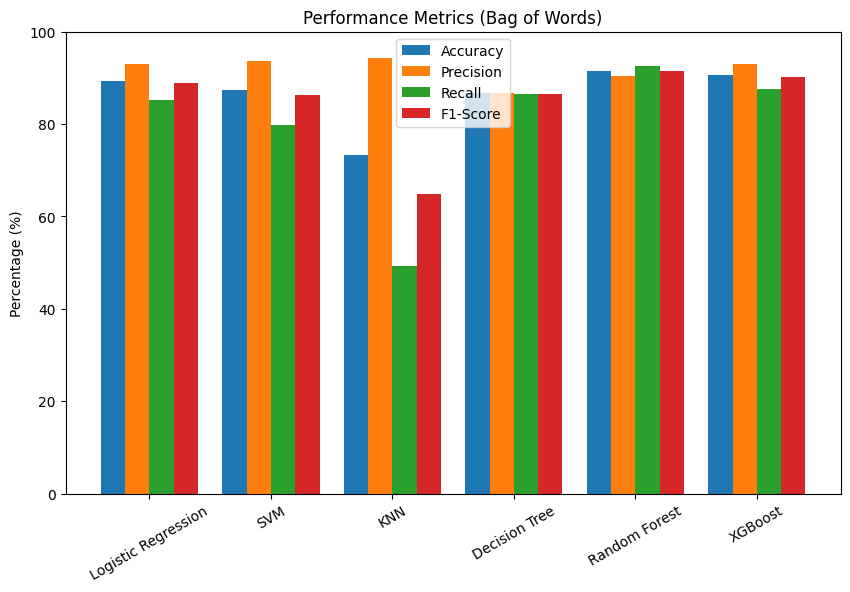

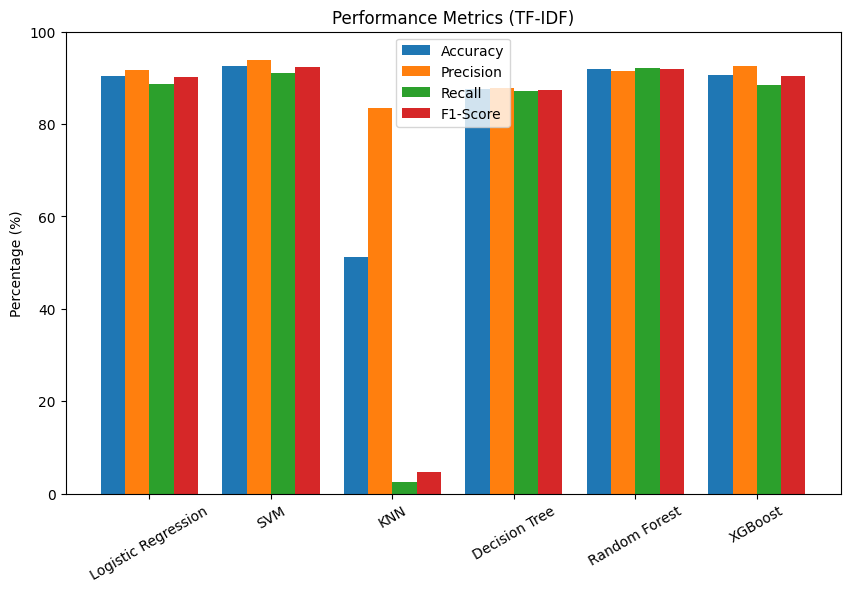

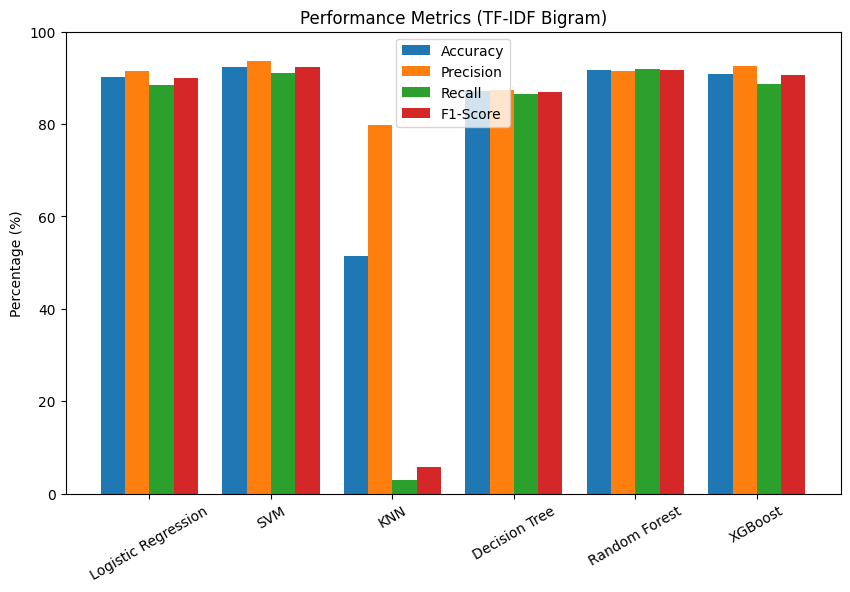

In [36]:

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to collect metrics for all models
def get_metrics(models, X_test, y_test):
    metrics = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-Score": []}

    for name, model in models.items():
        y_pred = model.predict(X_test)
        metrics["Model"].append(name)
        metrics["Accuracy"].append(accuracy_score(y_test, y_pred) * 100)
        metrics["Precision"].append(precision_score(y_test, y_pred) * 100)
        metrics["Recall"].append(recall_score(y_test, y_pred) * 100)
        metrics["F1-Score"].append(f1_score(y_test, y_pred) * 100)

    return metrics

# Function to plot grouped bar chart
def plot_metrics(metrics, title):
    labels = metrics["Model"]
    accuracy = metrics["Accuracy"]
    precision = metrics["Precision"]
    recall = metrics["Recall"]
    f1 = metrics["F1-Score"]

    x = np.arange(len(labels))  # label locations
    width = 0.2  # bar width

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy')
    rects2 = ax.bar(x - 0.5*width, precision, width, label='Precision')
    rects3 = ax.bar(x + 0.5*width, recall, width, label='Recall')
    rects4 = ax.bar(x + 1.5*width, f1, width, label='F1-Score')

    # Add labels
    ax.set_ylabel("Percentage (%)")
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30)
    ax.legend()

    plt.ylim(0, 100)
    plt.show()

# BoW metrics
bow_metrics = get_metrics(models_bow, X_test_bow, y_bow_test)
plot_metrics(bow_metrics, "Performance Metrics (Bag of Words)")

# TF-IDF metrics
tfidf_metrics = get_metrics(models_tfidf, X_test_tfidf, y_tfidf_test)
plot_metrics(tfidf_metrics, "Performance Metrics (TF-IDF)")

# TF-IDF Bigram metrics
tfidf_bi_metrics = get_metrics(models_tfidf_bi, X_test_tfidf_bi, y_tfidf_test_bi)
plot_metrics(tfidf_bi_metrics, "Performance Metrics (TF-IDF Bigram)")


In [39]:
import joblib
from google.colab import drive


save_path = "/content/drive/MyDrive/saved_models/"


# Save Bag of Words (BoW) model + vectorizer
joblib.dump(models_bow, save_path + "model_bow.pkl")
joblib.dump(bow, save_path + "vectorizer_bow.pkl")

# Save TF-IDF model + vectorizer
joblib.dump(models_tfidf, save_path + "model_tfidf.pkl")
joblib.dump(tfidf, save_path + "vectorizer_tfidf.pkl")

# Save TF-IDF Bigram model + vectorizer
joblib.dump(models_tfidf_bi, save_path + "model_tfidf_bi.pkl")
joblib.dump(tfidf_bi, save_path + "vectorizer_tfidf_bi.pkl")

print("✅ All models and vectorizers saved to Google Drive!")


✅ All models and vectorizers saved to Google Drive!


In [33]:
def preprocess_user_text(text):
    """Apply all your preprocessing functions in order."""
    text = text.lower()
    text = remove_html(text)
    text = remove_urls(text)
    text = remove_punc(text)
    text = remove_digits(text)
    text = remove_stopwords(text)
    text = remove_special_characters(text)
    text = lemmatize_text(text)
    return text


In [47]:
user_text = input("Enter your text: ")

# Preprocess it
clean_text = preprocess_user_text(user_text)

# Convert to TF-IDF (or BOW) vector
vec_text = tfidf.transform([clean_text])  # Use tfidf or bow depending on your model

# Make prediction
pred = models_tfidf["SVM"].predict(vec_text)
pred_lr = models_tfidf["Logistic Regression"].predict(vec_text)

# Show results
print("\nCleaned text for model:", clean_text)
print("Prediction (SVM):", pred[0])
print("Prediction (Logistic Regression):", pred_lr[0])

Enter your text: I went out with my friends and had a great time!

Cleaned text for model: went friend great time
Prediction (SVM): 0
Prediction (Logistic Regression): 0


In [48]:
texts = ["I feel hopeless and drained every day.",
         "Everything feels pointless and I don't enjoy anything anymore.",
         "I can't find the energy to talk to anyone or do anything.",


    "I went out with my friends and had a great time!",
    "I finally completed my project and I feel accomplished.",
    "I had a relaxing day at the park and read my favorite book.",
    "I haven't been able to sleep properly or get out of bed."

]

for text in texts:
   clean_txt = preprocess_user_text(text)
   vec_text = tfidf.transform([clean_txt])

   pred = models_tfidf["SVM"].predict(vec_text)

   pred_2 = models_tfidf["Logistic Regression"].predict(vec_text)

   print("Prediction_SVM:", pred[0])
   print("Prediction_LR:", pred_2[0])

Prediction_SVM: 1
Prediction_LR: 1
Prediction_SVM: 1
Prediction_LR: 1
Prediction_SVM: 1
Prediction_LR: 1
Prediction_SVM: 0
Prediction_LR: 0
Prediction_SVM: 1
Prediction_LR: 1
Prediction_SVM: 0
Prediction_LR: 0
Prediction_SVM: 0
Prediction_LR: 0


In [36]:
from lime.lime_text import LimeTextExplainer
import numpy as np

# Example: Best model = SVM trained on TF-IDF
best_model = LogisticRegression(max_iter=1000)  # retrain with probability=True for LIME
best_model.fit(X_train_tfidf, y_tfidf_train)

# Define class names
class_names = ["Non-Depression", "Depression"]

# Create explainer
explainer = LimeTextExplainer(class_names=class_names)

# Sample text
sample_text = "I finally completed my project and I feel accomplished."

# Explain prediction
exp = explainer.explain_instance(
    sample_text,
    classifier_fn=lambda x: best_model.predict_proba(tfidf.transform(x)),
    num_features=10
)

# Show explanation
exp.show_in_notebook(text=True)   # if in Jupyter/Colab
# OR save as HTML
exp.save_to_file('lime_explanation.html')


In [ ]:
from lime.lime_text import LimeTextExplainer
import numpy as np

# Example: Best model = SVM trained on TF-IDF
best_model = LogisticRegression(max_iter=1000,probability=True)  # retrain with probability=True for LIME
best_model.fit(X_train_tfidf, y_tfidf_train)

# Define class names
class_names = ["Non-Depression", "Depression"]

# Create explainer
explainer = LimeTextExplainer(class_names=class_names)

# Sample text
sample_text = "I feel so hopeless and tired of everything in life."

# Explain prediction
exp = explainer.explain_instance(
    sample_text,
    classifier_fn=lambda x: best_model.predict_proba(tfidf.transform(x)),
    num_features=10
)

# Show explanation
exp.show_in_notebook(text=True)   # if in Jupyter/Colab
# OR save as HTML
exp.save_to_file('lime_explanation.html')


In [33]:
import shap

# Define a prediction function that combines vectorizer + model
def predict_proba(texts):
    X = tfidf.transform(texts)        # transform raw text
    return best_model.predict_proba(X)  # return probabilities

# Create SHAP explainer with masker="text" for raw text
explainer = shap.Explainer(predict_proba, shap.maskers.Text())

# Pick a few test samples
sample_texts = [
    "I am so depressed and don't want to live.",
    "Today was a good day, I feel happy."
]

# Explain
shap_values = explainer(sample_texts)

# Plot explanation for the first sample
shap.plots.text(shap_values[0])


In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

def clean_texts(texts):
    return [preprocess_user_text(t) for t in texts]


# Example pipeline
pipeline = Pipeline([
    ('cleaning', FunctionTransformer(clean_texts, validate=False)),
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Fit the pipeline on your training data
pipeline.fit(X_train, y_train)


Pipeline(steps=[('cleaning',
                 FunctionTransformer(func=<function clean_texts at 0x792b3f0b2160>)),
                ('tfidf', TfidfVectorizer(max_features=1000)),
                ('classifier', LogisticRegression(max_iter=1000))])

In [45]:
pred = pipeline.predict(["I am so depressed and don't want to live."])
print(pred)

[1]


In [46]:
from lime.lime_text import LimeTextExplainer

# Define class names
class_names = ["Non-Depression", "Depression"]

# Create explainer
explainer = LimeTextExplainer(class_names=class_names)

# Sample text
sample_text = "I finally completed my project and I feel accomplished."

# Explain prediction
exp = explainer.explain_instance(
    sample_text,
    classifier_fn=pipeline.predict_proba,
    num_features=10
)

# Show explanation
exp.show_in_notebook(text=True)   # if in Jupyter/Colab

In [47]:
import joblib

path="/content/drive/MyDrive/saved_models/"

joblib.dump(pipeline,path+"text_pipeline.pkl")


['/content/drive/MyDrive/saved_models/text_pipeline.pkl']